In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
auth = np.loadtxt('twitter_auth_key.txt', dtype=str).tolist() #Replace with your Twitter API key
client = tweepy.Client(auth)

v1auth = tweepy.OAuth2BearerHandler(auth)
v1API = tweepy.API(v1auth)

In [4]:
def get_user_id(username):
    user = client.get_user(username=username)
    return user.data.id

In [5]:
def hindex_full(list_, scale=100000, step=50, max_depth=5, percentile=90):
    
    grades = [scale]
    for i in range(max_depth):
        scale /= step
        grades.append(scale)
        
    for g in grades:
        if np.percentile(list_, percentile) >= g:
            scale = g
            break
    else:
        scale = min(grades)
    
    hind = hindex(list_, scale) 
    
    return (hind + 1) * scale, scale

def hindex(list_, scale):
    arr = np.array(list_)
    arr = np.sort(arr)[::-1]
    
    idx = np.arange(1,len(arr)+1)*scale
    
    try:
        return np.max(np.argwhere(arr >= idx))
    except:
        return -1
    
def hindex_df(list_, scale):
    scores_arr = np.sort(np.array(list_))[::-1]
    idx_arr = np.arange(1,len(scores_arr)+1)*scale
    
    df = pd.DataFrame({
        'Scores': scores_arr,
        'Idx': idx_arr
    }).set_index('Idx').head(np.max(np.argwhere(scores_arr >= idx_arr))+2)
    
    return df

In [11]:
def calculate_authority(user_id, max_results=50, display_results=True):
    #Get the tweets
    tweets = client.get_users_tweets(user_id, max_results=max_results, tweet_fields='public_metrics', exclude=['retweets', 'replies'])
    
    #Get the scores
    scores = []
    try:
        for tweet in tweets.data:
            scores.append(sum(tweet.public_metrics.values()))
    except:
        scores.append(0)
    
    #Get the hindex
    score, scale = hindex_full(scores)
    
    if display_results:
        print(f'User: {user_id}')
        print(f'Score: {score}')
        print(f'Scale: {scale}')
        print()
        print(f'Of their last {len(scores)} tweets, {user_id} has {score / scale} tweets with engagement >= {score}:')
        print()
        print(hindex_df(scores, scale))
        
        plt.plot(scores[::-1])
        plt.xlabel(f'Most recent tweets ({len(scores)} is most recent)')
        plt.ylabel('Engagement')
        plt.show()
    
    return score

User: 1605
Score: 12000.0
Scale: 2000.0

Of their last 50 tweets, 1605 has 6.0 tweets with engagement >= 12000.0:

         Scores
Idx            
2000.0    58049
4000.0    33107
6000.0    18562
8000.0    14669
10000.0   14558
12000.0   12977
14000.0   11382


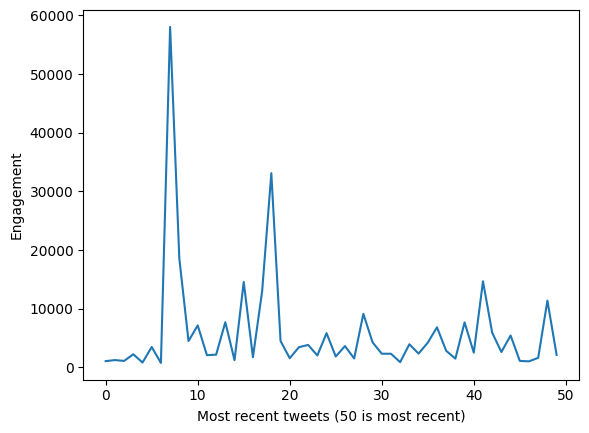

12000.0

In [12]:
calculate_authority(get_user_id('sama'))

In [13]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.scoutzen.com/twitter-lists/search?q=apple'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

In [14]:
tbody = soup.find('tbody')
links = tbody.find_all('a')

rows = []

for link in links:
    list_text = link.text
    owner = link.text.split('/')[0][1:]
    title = link.text.split('/')[1]
    
    #Get the List ID
    try:
        response = v1API.get_list(slug=title, owner_screen_name=owner)
        rows.append(
            (
                response.id,
                response.name,
                response.user.screen_name,
                response.subscriber_count,
                response.member_count
            )
        )
    except:
        continue

In [15]:
list_df = pd.DataFrame(rows, columns=['List_ID', 'List_name', 'List_owner', 'Subscribers', 'Members'])
list_df['ratio'] = list_df['Subscribers'] / list_df['Members']
list_df['weight'] = list_df['ratio'] / list_df['ratio'].sum()
list_df

,List_ID,List_name,List_owner,Subscribers,Members,ratio,weight
0,8486792,Apple Employees,jerols,868,49,17.714286,0.379678
1,21574836,apple,skybless,323,304,1.062500,0.022773
2,34419071,Apple Twitter Accounts,applespotlight,298,18,16.555556,0.354843
3,222348536,Apple,Mobarmijoun_ar,237,3620,0.065470,0.001403
4,33420622,apple2,skybless,170,186,0.913978,0.019590
5,94809311,Tech,BreakingNews,258,65,3.969231,0.085074
6,43371341,Apple Top 25,thenextweb,153,24,6.375000,0.136638


In [16]:
user_df = pd.DataFrame()

for _,row in list_df.iterrows():
    list_id = row['List_ID']
    score = row['weight']
    members = row['Members']
    
    print(list_id)
    
    next_token = None
    
    user_ids = []
    user_names = []
    scores = [score for i in range(members)]
    page_tracker = 1
    
    while len(user_ids) < members:
        if next_token == None:
            response = client.get_list_members(list_id)
            try:
                next_token = response.meta['next_token']
            except:
                None
        else:
            response = client.get_list_members(list_id, pagination_token=next_token)
            try:
                next_token = response.meta['next_token']
            except:
                next_token = None
            
        print(f'Current page: {page_tracker}')
        user_ids.extend([r.id for r in response.data])
        user_names.extend([r.username for r in response.data])
        page_tracker += 1
    
    temp_df = pd.DataFrame(zip(user_ids, user_names, scores), columns=['User_ID', 'Username', 'Score'])
    user_df = pd.concat([user_df, temp_df])
    
user_df

8486792
Current page: 1
21574836
Current page: 1
Current page: 2
Current page: 3
Current page: 4
34419071
Current page: 1
222348536
Current page: 1
Current page: 2
Current page: 3
Current page: 4
Current page: 5
Current page: 6
Current page: 7
Current page: 8
Current page: 9
Current page: 10
Current page: 11
Current page: 12
Current page: 13
Current page: 14
Current page: 15
Current page: 16
Current page: 17
Current page: 18
Current page: 19
Current page: 20
Current page: 21
Current page: 22
Current page: 23
Current page: 24
Current page: 25
Current page: 26
Current page: 27
Current page: 28
Current page: 29
Current page: 30
Current page: 31
Current page: 32
Current page: 33
Current page: 34
Current page: 35
Current page: 36
Current page: 37
33420622
Current page: 1
Current page: 2
Current page: 3
94809311
Current page: 1
43371341
Current page: 1


,User_ID,Username,Score
0,1014766195,themikestern,0.379678
1,166369152,forstall,0.379678
2,64641371,espresso,0.379678
3,61805492,Cranfillec,0.379678
4,43620739,funnest,0.379678
...,...,...,...
19,652193,mgsiegler,0.136638
20,636923,siracusa,0.136638
21,174853,Gartenberg,0.136638
22,39093,ianbetteridge,0.136638


In [17]:
user_df_duplicates = user_df[user_df.duplicated(subset=['User_ID', 'Username'], keep=False)]
user_df_agg = user_df_duplicates.groupby(['User_ID', 'Username'])['Score'].sum().reset_index()
user_df_agg = user_df_agg.sort_values(by='Score', ascending=False)
user_df_agg

,User_ID,Username,Score
0,16120265,inafried,0.221713
1,97909264,skybless,0.042363
2,954863712,va_jh,0.039179


In [18]:
user_df_agg['Authority'] = user_df_agg['User_ID'].apply(lambda x: calculate_authority(x, display_results=False))
user_df_agg['Weighted_Authority'] = user_df_agg['Score'] * user_df_agg['Authority']
user_df_agg.sort_values(by='Weighted_Authority', ascending=False).head(20)

,User_ID,Username,Score,Authority,Weighted_Authority
0,16120265,inafried,0.221713,40.0,8.868507
2,954863712,va_jh,0.039179,1.6,0.062687
1,97909264,skybless,0.042363,0.0,0.000000
